In [173]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs

from importlib import reload
import calculation_functions
import load_dataset as load
import phase_calc_functions as phase_calc
import constants

# Test 'wet_season_year'

## Mock Data Test

There is a need to test the 'wet_season_year' funciton. The aim of this function is to put all the data from one monsoon (months = [12,1,2,3]) into a single year. This should be doen by moving the data from months [1,2,3] backwards by 365 days so that they all coincide with a single year.

Test ideas:
* Data for one monsoons should all be same order of magnitude and a multiple of 10. Thus the sum of the data across the monsoon will be equal to the number of days multiplied by the order of magnitude for that monsoon.

In [285]:
def generate_mock_magnitude_awap_data(debug:bool=False):
    '''Generates mock data with values that increment by a factor of 10 each time a monsoon
    finishes. This can be used to check the wet_season_year function is correctly aligning everything'''

    time = pd.date_range(start='1974-06-01', end='1980-03-31', freq='1D')
    if debug: print(f"{time=}")

    unique_years = np.array(np.unique(time.year))
    if debug: print(f"{unique_years=}")

    year_assigned_magnitude = 10 ** (unique_years - unique_years[0])
    if debug: print(f'{year_assigned_magnitude=}')

    lat = np.linspace(-25, -10, 10)
    lon = np.linspace(110, 135, 10)

    mock_single_month_stor = []
    for year in unique_years:

        year_int = year - unique_years[0]

        single_year_time = time[time.year == year]

        months_in_year = np.unique(single_year_time.month)

        for month in months_in_year:

            #magntidue_int = year_int
            #if month in constants.END_MONSOON_MONTHS:
            #    magntidue_int = year_int-1
            #value_to_assign = year_assigned_magnitude[magntidue_int]
            if month in constants.END_MONSOON_MONTHS:
                value_to_assign = year_assigned_magnitude[year_int]
            else:
                value_to_assign = 0
            if debug: print(f'{year=} {month=}, {value_to_assign=}')

            single_year_and_month_time = single_year_time[single_year_time.month == month]

            number_days_in_month = len(single_year_and_month_time)

            mock_month_data = np.zeros((number_days_in_month, len(lon), len(lat))) + value_to_assign

            mock_single_month_ds = xr.Dataset({'precip':(('time', 'lon', 'lat'), mock_month_data)},
                                               {'time': single_year_and_month_time, 'lon': lon, 'lat': lat })
            mock_single_month_stor.append(mock_single_month_ds)
    mock_ds = xr.concat(mock_single_month_stor, dim='time')
    return mock_ds

In [286]:
mock_ds = generate_mock_magnitude_awap_data(debug=False)
mock_ds_ws  = phase_calc.wet_season_year(mock_ds)

In [287]:
mock_yearly_sum_ds = calculation_functions.resample_sum(mock_ds)
mock_monsoon_sum_ds = calculation_functions.resample_sum(mock_ds_ws)
mock_monsoon_sum_ds

<xarray.Dataset>
Dimensions:  (year: 6, lon: 10, lat: 10)
Coordinates:
  * lon      (lon) float64 110.0 112.8 115.6 118.3 ... 126.7 129.4 132.2 135.0
  * lat      (lat) float64 -25.0 -23.33 -21.67 -20.0 ... -13.33 -11.67 -10.0
  * year     (year) int64 1974 1975 1976 1977 1978 1979
Data variables:
    precip   (year, lon, lat) float64 900.0 900.0 900.0 ... 9.1e+07 9.1e+07

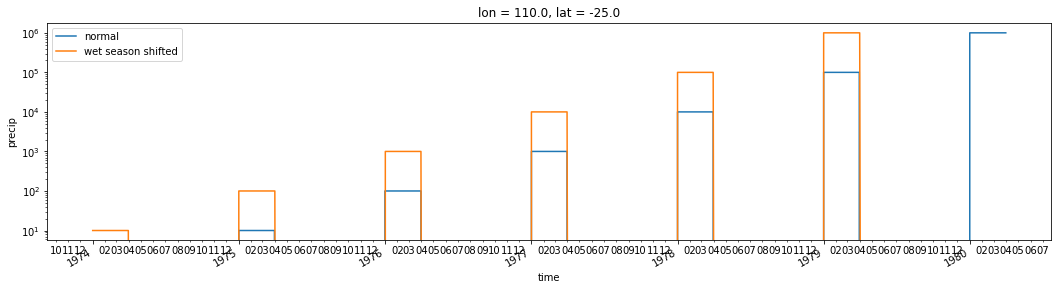

In [288]:
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(111)
mock_ds.isel(lat=0, lon=0).precip.plot(ax=ax, label='normal')
mock_ds_ws.isel(lat=0, lon=0).precip.plot(ax=ax, label='wet season shifted')

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%m')
ax.legend()
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmt)
plt.yscale('log')

In [295]:
# expected_values = [121] * 7

# output_yearly = mock_yearly_sum_ds.isel(lat=0, lon=0).precip.values/year_assigned_magnitude

# output_monsoon = mock_monsoon_sum_ds.isel(lat=0, lon=0).precip.values/year_assigned_magnitude[:-1]
# print(f'{output_yearly=}',f'{output_monsoon=}' , sep='\n')

In [130]:
# # These should be equal 
# np.testing.assert_almost_equal(output_monsoon, expected_values[:-1], decimal=0)
# # These should not be equal
# np.testing.assert_equal(any(np.not_equal(output_monsoon, expected_values[:-1])), True)

## Actual Data

* All the data for month 12 should match. 
* The data for months [1,2,3] in _ws version should match with the data for same months in the next year

In [168]:
# Loading awap
awap = load.load_awap()
rmm = load.load_rmm()

awap_ws = phase_calc.wet_season_year(awap)
rmm_ws = phase_calc.wet_season_year(rmm)

In [225]:
test_months = constants.START_MONSOON_MONTHS

awap_end = awap.where(awap.time.dt.month.isin(test_months), drop=True)
awap_end_ws = awap_ws.where(awap_ws.time.dt.month.isin(test_months), drop=True)

awap_end_years = np.unique(awap_end.time.dt.year.values)
awap_ws_end_years = np.unique(awap_end_ws.time.dt.year.values)

number_years = len(awap_end_years)

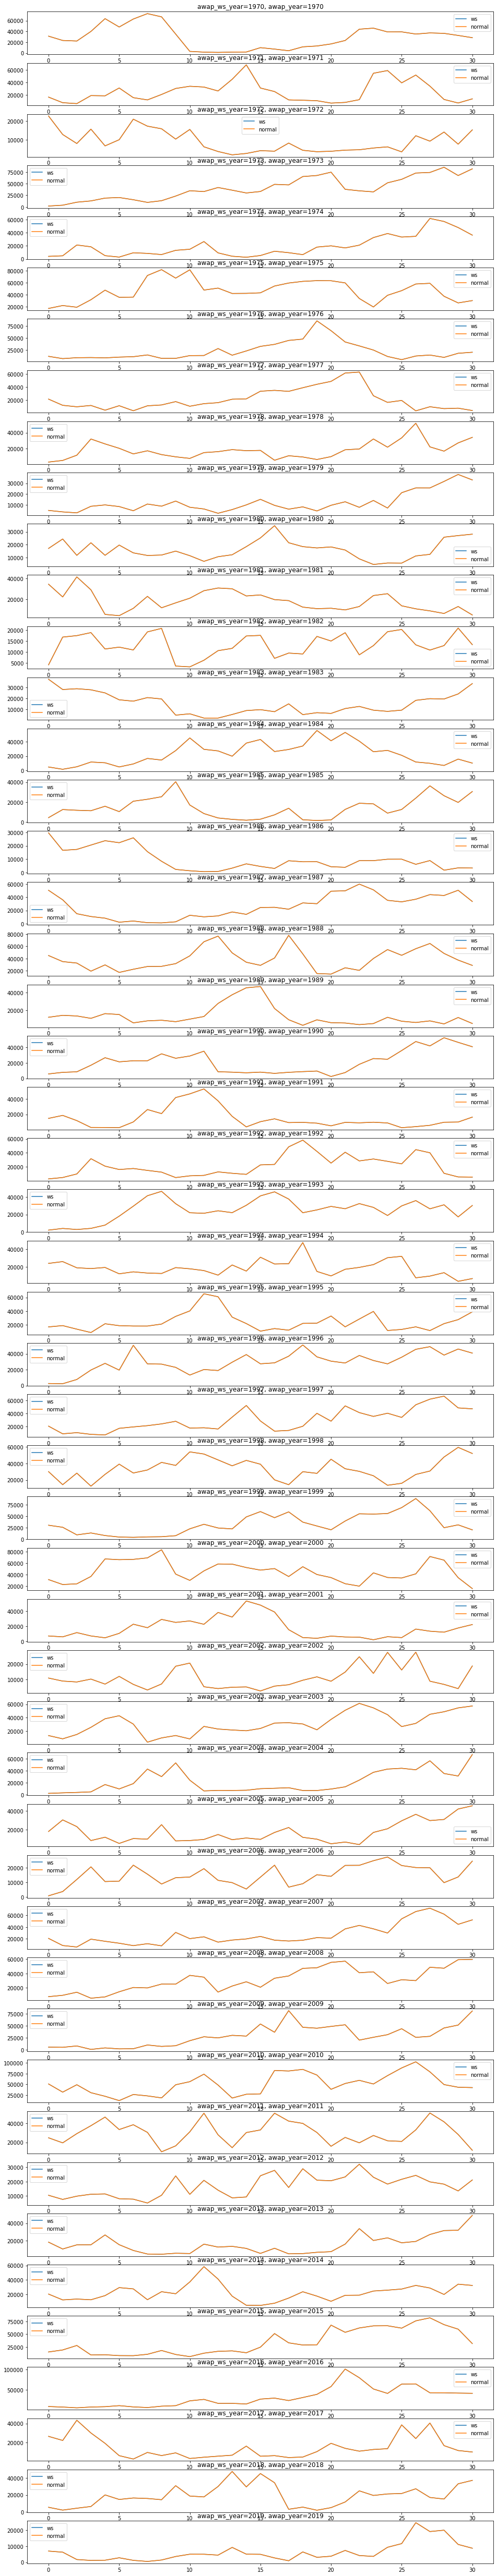

In [229]:
fig, axs = plt.subplots(number_years, figsize=(16, 90))

for year_int in range(number_years):
    ax = axs[year_int]
    awap_ws_year = awap_ws_end_years[year_int]
    awap_year = awap_end_years[year_int]
    ds_ws = awap_end_ws.where(awap_end_ws.time.dt.year.isin([awap_ws_year]), drop=True)
    ds = awap_end.where(awap_end.time.dt.year.isin([awap_year]), drop=True)
    
    ax.set_title(f'{awap_ws_year=}, {awap_year=}')
    ax.plot(ds_ws.precip.sum(dim=['lat', 'lon']).values, label='ws')
    ax.plot(ds.precip.sum(dim=['lat', 'lon']).values, label='normal')
    ax.legend()

In [234]:
test_months = constants.START_MONSOON_MONTHS

rmm_end = rmm.where(rmm.time.dt.month.isin(test_months), drop=True)
rmm_end_ws = rmm_ws.where(rmm_ws.time.dt.month.isin(test_months), drop=True)

rmm_end_years = np.unique(rmm_end.time.dt.year.values)
rmm_ws_end_years = np.unique(rmm_end_ws.time.dt.year.values)

number_years = len(rmm_end_years)

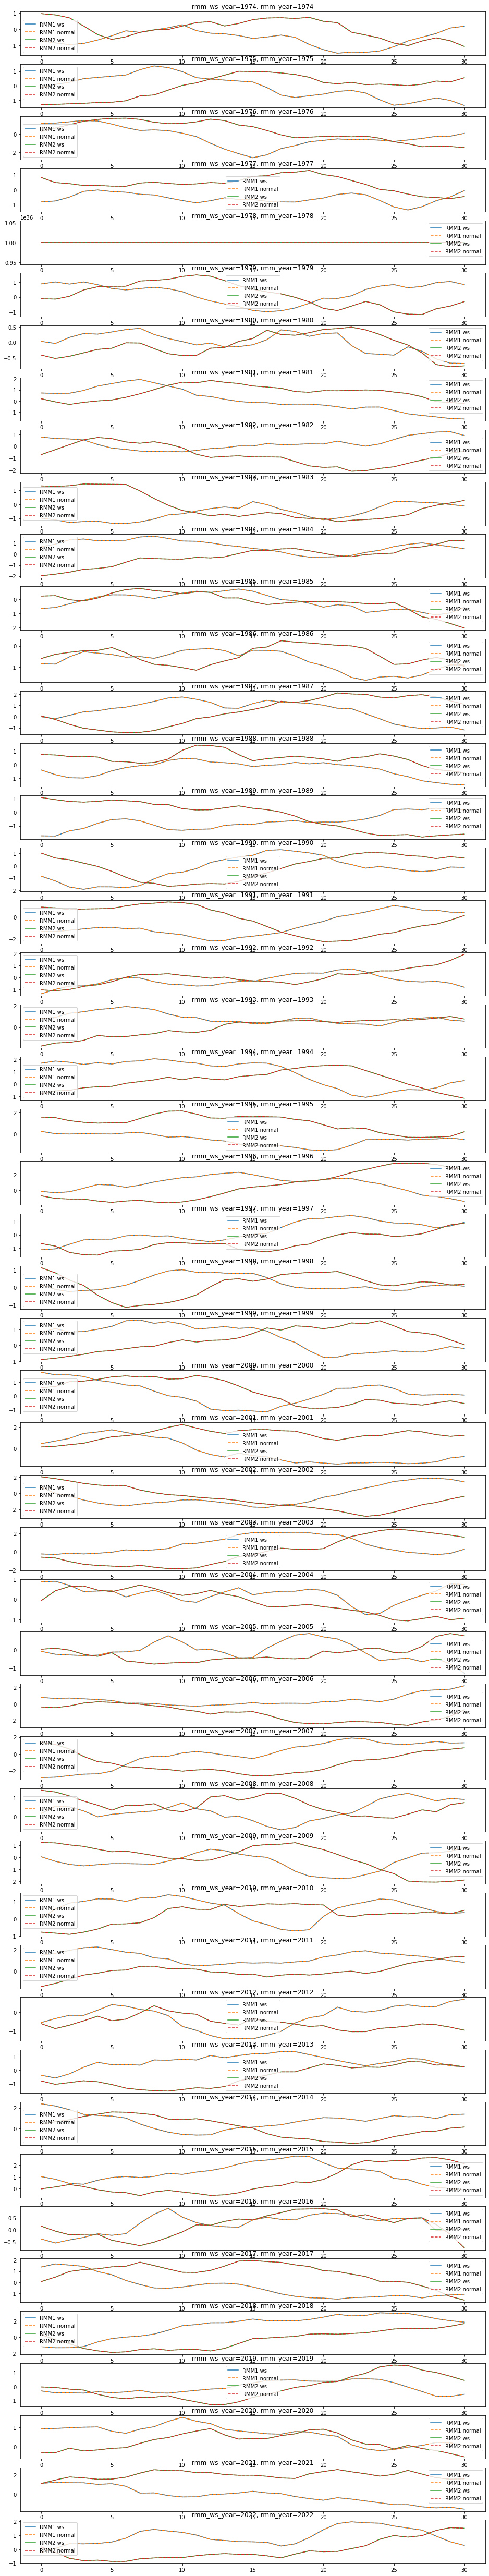

In [235]:
fig, axs = plt.subplots(number_years, figsize=(16, 90))

for year_int in range(number_years):
    ax = axs[year_int]
    rmm_ws_year = rmm_ws_end_years[year_int]
    rmm_year = rmm_end_years[year_int]
    ds_ws = rmm_end_ws.where(rmm_end_ws.time.dt.year.isin([rmm_ws_year]), drop=True)
    ds = rmm_end.where(rmm_end.time.dt.year.isin([rmm_year]), drop=True)
    
    ax.set_title(f'{rmm_ws_year=}, {rmm_year=}')
    ax.plot(ds_ws.RMM1.values, label='RMM1 ws')
    ax.plot(ds.RMM1.values, label='RMM1 normal', linestyle='--')
    ax.plot(ds_ws.RMM2.values, label='RMM2 ws')
    ax.plot(ds.RMM2.values, label='RMM2 normal', linestyle='--')
    ax.legend()

# Test split_into_1to8

In [236]:
# Loading awap
awap = load.load_awap()
rmm = load.load_rmm()

awap_ws = phase_calc.wet_season_year(awap)
rmm_ws = phase_calc.wet_season_year(rmm)

In [237]:
awap_split_ws = phase_calc.split_into_1to8(awap_ws, rmm_ws)

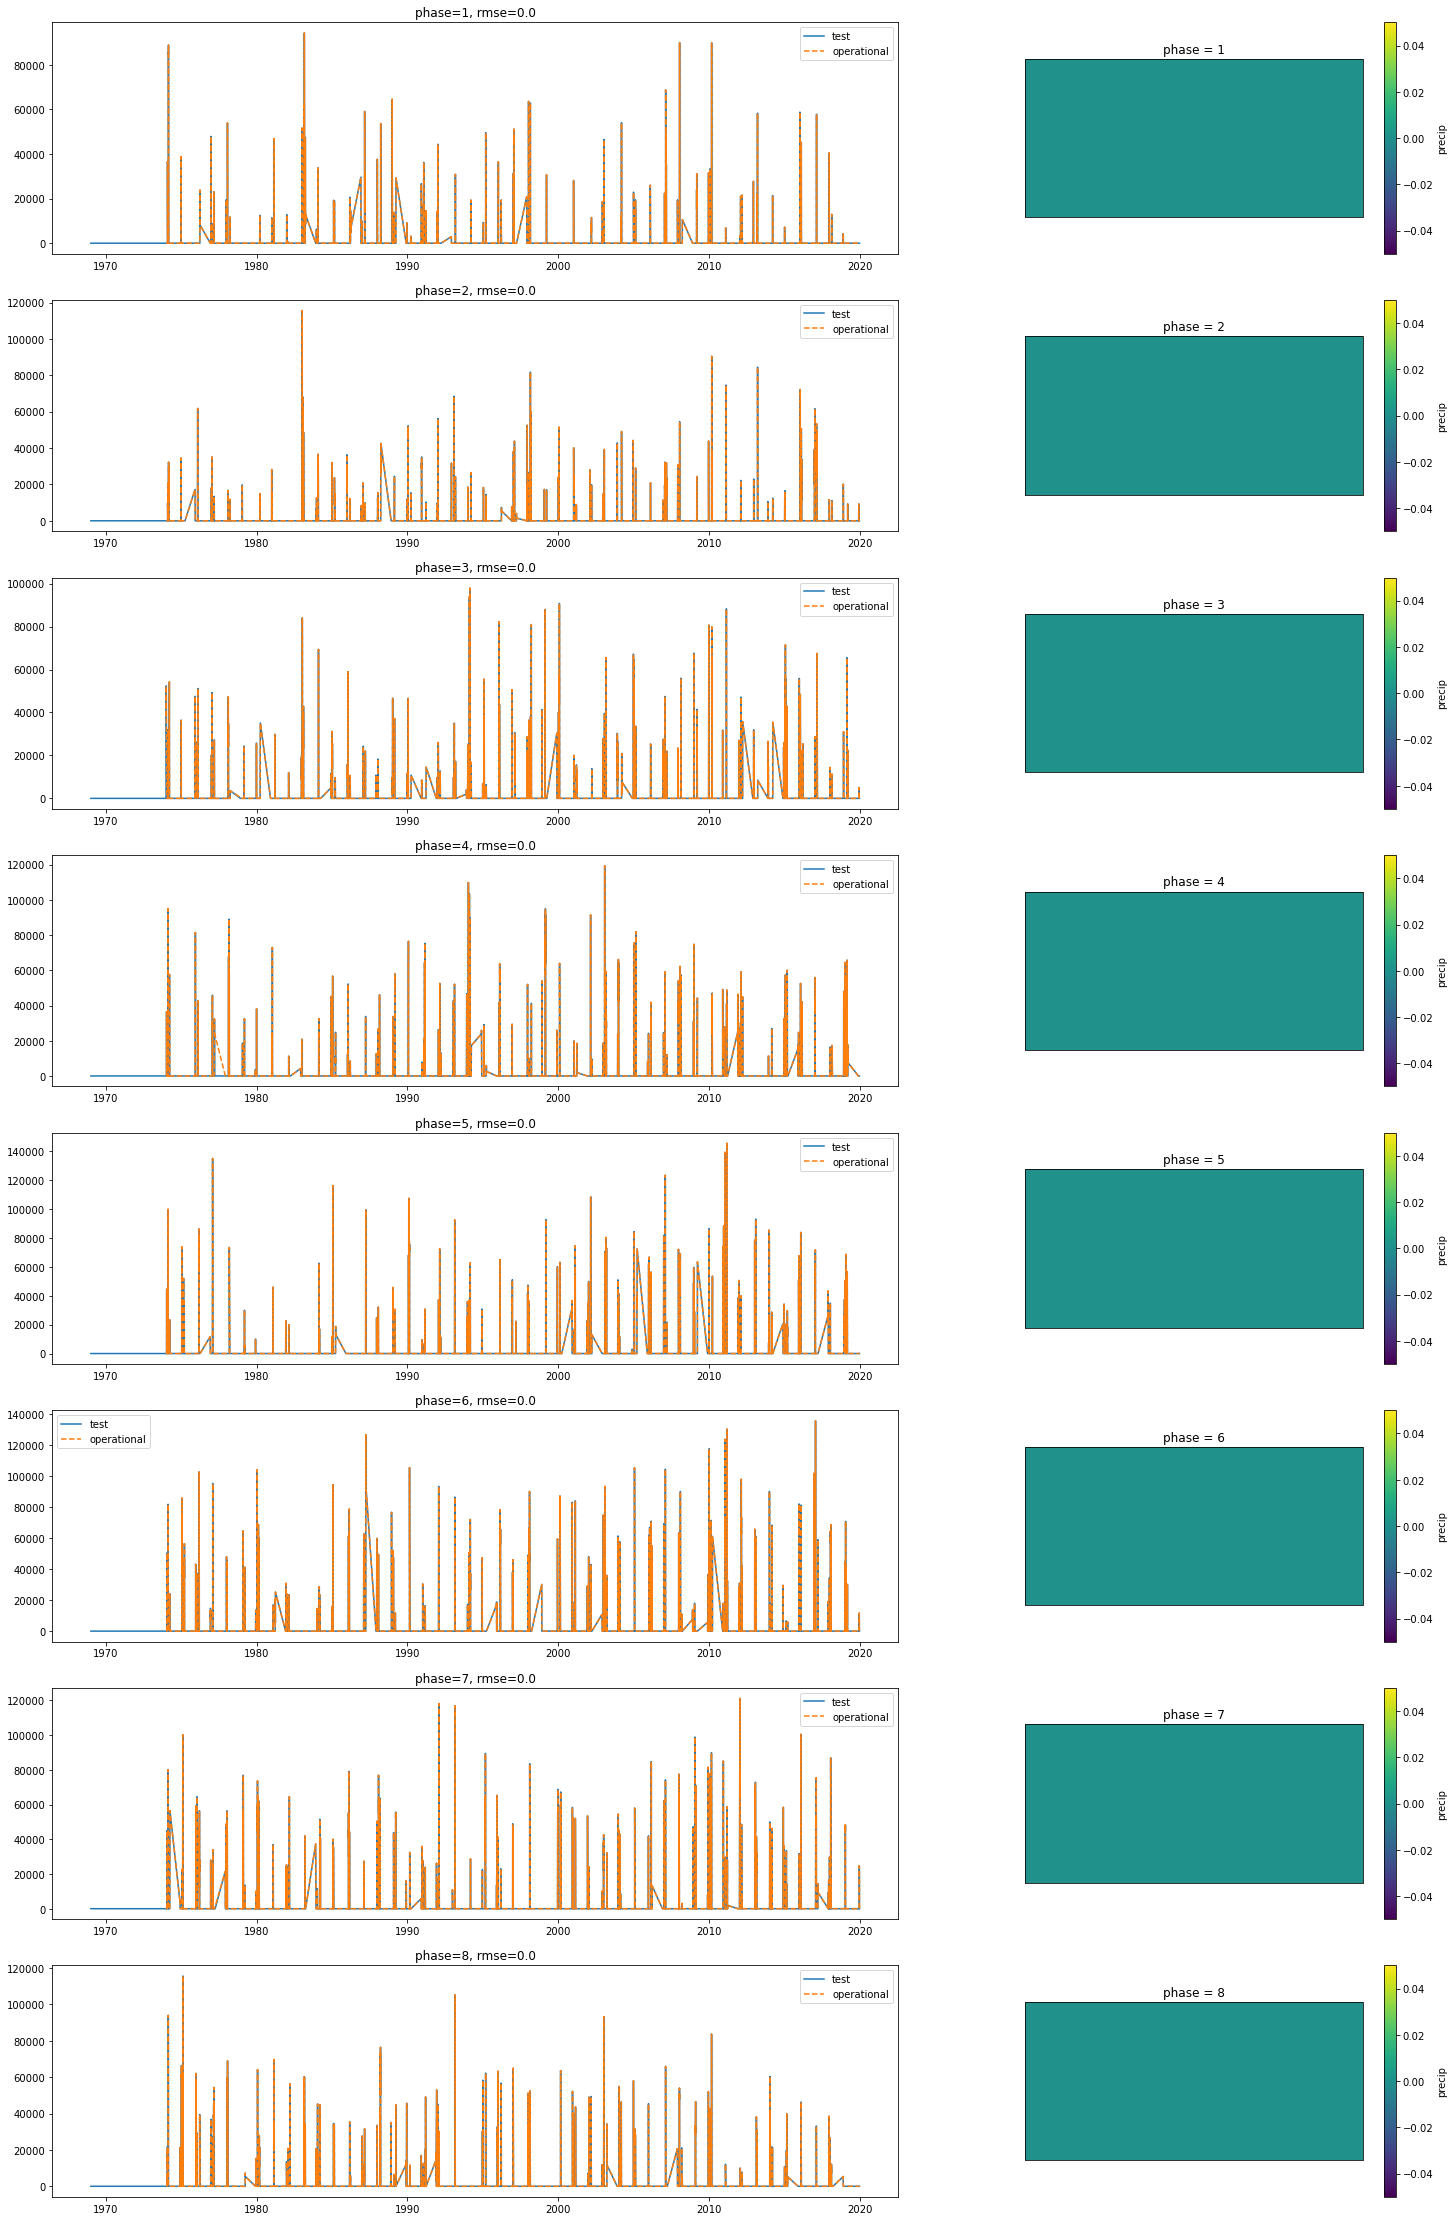

In [294]:
phases = np.arange(1,9) # Don't want phase 0 (inactive phase)#awap_split_ws.phase.values
fig = plt.figure(figsize=(25, 5 * len(phases)))
gs = gridspec.GridSpec(len(phases), 2, width_ratios=[1, 0.5])

for plot_num,phase in enumerate(phases):

    rmm_ws_single_phase = rmm_ws.where(np.logical_and(rmm_ws.amplitude>1, rmm_ws.phase==phase), drop=True)
    awap_single_phase = awap_ws.where(awap_ws.time.isin(rmm_ws_single_phase.time.values))

    ax1 = fig.add_subplot(gs[plot_num, 0])
    ax1.plot(awap_single_phase.time.values, awap_single_phase.precip.sum(dim=['lat', 'lon']).values,
           label='test')
    ax1.plot(awap_split_ws.time.values, awap_split_ws.sel(phase=phase).precip.sum(dim=['lat', 'lon']).values,
           linestyle='--', label='operational')
    ax1.legend()
    
    rmse = awap_single_phase.precip.sum(dim=['lat', 'lon']) -  awap_split_ws.sel(phase=phase).precip.sum(dim=['lat', 'lon'])

    rmse = np.mean(np.sqrt(rmse.values**2))
    
    ax1.set_title(f'{phase=}, {rmse=}')

    ax2 = fig.add_subplot(gs[plot_num, 1], projection=ccrs.PlateCarree())
    (awap_split_ws.sel(phase=phase).precip.sum(dim='time') - awap_single_phase.precip.sum(dim='time')).plot(ax=ax2)